# Modeling


We have saved 2 files after feature engineering. 
1. Crash data with other tables(people and vehicle) with all of new variables added
2. Same data with above but imputed columns with 90% missing rate

For all datasets, use the model shown below (with the exact hyperparameters).

+ control: only the data in the **Crashes** files.
+ test one: the data in Crashes files with selective feature engineering of the data recorded from the **people and vehicle** files
+ test two: test one file with highly correlated variables removed.

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')
# File system manangement
import os

plt.style.use('fivethirtyeight')

In [2]:
!pip install lightgbm
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt
from sklearn import preprocessing

In [3]:
def model(features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['RD_NO']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['RD_NO', 'TARGET'])

    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
#     test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 2002)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
#     test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 2002)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
#         test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
#     submission = pd.DataFrame({'RD_NO': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return feature_importances, metrics

In [4]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

## Control
The first step in any experiment is establishing a control. For this we will use the function defined above (that implements a Gradient Boosting Machine model) and the single main data source (crashes only).

In [5]:
print(os.listdir("../input"))

['Traffic_Crashes_-_Crashes.csv', 'Traffic_Crashes_-_People.csv', 'Traffic_Crashes_-_Vehicles.csv', 'train_control_damage.csv', 'train_new.csv', 'train_people_vehicle_corrs_removed.csv', 'train_people_vehicle_raw.csv']


In [6]:
# read in data
categoricals = ['CRASH_DATE_EST_I', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE',
                'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND',
                'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
                'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
                'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I',
                'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I',
                'MOST_SEVERE_INJURY', 'BEAT_OF_OCCURRENCE','CRASH_HOUR','CRASH_MONTH','CRASH_DAY_OF_WEEK','YEAR']
dtypes = dict.fromkeys(categoricals, 'category')


train_control = pd.read_csv('../input/train_control_damage.csv', dtype = dtypes)
train_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207101 entries, 0 to 207100
Data columns (total 42 columns):
RD_NO                            207101 non-null object
CRASH_DATE_EST_I                 13902 non-null category
POSTED_SPEED_LIMIT               207101 non-null int64
TRAFFIC_CONTROL_DEVICE           207101 non-null category
DEVICE_CONDITION                 207101 non-null category
WEATHER_CONDITION                207101 non-null category
LIGHTING_CONDITION               207101 non-null category
FIRST_CRASH_TYPE                 207101 non-null category
TRAFFICWAY_TYPE                  207101 non-null category
LANE_CNT                         136971 non-null object
ALIGNMENT                        207101 non-null object
ROADWAY_SURFACE_COND             207101 non-null category
ROAD_DEFECT                      207101 non-null category
REPORT_TYPE                      202378 non-null category
CRASH_TYPE                       207101 non-null category
INTERSECTION_RELATED_I       

In [7]:
fi, metrics = model(train_control)

Training Data Shape:  (207101, 579)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.738724	train's binary_logloss: 0.595193	valid's auc: 0.717144	valid's binary_logloss: 0.601097
[400]	train's auc: 0.755572	train's binary_logloss: 0.584931	valid's auc: 0.718676	valid's binary_logloss: 0.6001
Early stopping, best iteration is:
[466]	train's auc: 0.760191	train's binary_logloss: 0.582054	valid's auc: 0.719076	valid's binary_logloss: 0.599897
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.739543	train's binary_logloss: 0.595215	valid's auc: 0.722792	valid's binary_logloss: 0.602752
[400]	train's auc: 0.756301	train's binary_logloss: 0.585189	valid's auc: 0.725314	valid's binary_logloss: 0.601174
[600]	train's auc: 0.769598	train's binary_logloss: 0.576716	valid's auc: 0.726678	valid's binary_logloss: 0.600136
[800]	train's auc: 0.78059	train's binary_logloss: 0.569223	valid's auc: 0.727727	valid's binary_logloss: 0.599

In [8]:
metrics

,fold,train,valid
0,0,0.760191,0.719076
1,1,0.811427,0.729782
2,2,0.764550,0.726418
3,3,0.782530,0.732940
4,4,0.784360,0.689010
5,overall,0.780612,0.720203


+ The control slightly overfits because the training score is higher than the validation score. 
>we already perform some regularization in this model by using reg_lambda and reg_alpha as well as early stopping but other regularization technique might be required.

+ We can visualize the feature importance with another function, plot_feature_importances. The feature importances may be useful when it's time for feature selection.

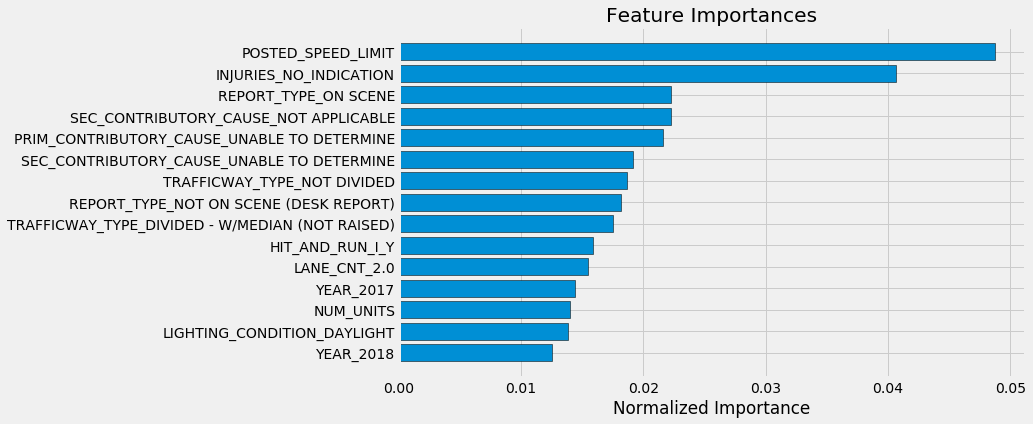

In [9]:
fi_sorted = plot_feature_importances(fi)

## Test One
Let's conduct the first test. We will just need to pass in the data to the function, which does most of the work for us.

In [10]:
# read in data

train = pd.read_csv('../input/train_people_vehicle_raw.csv',decimal = ',', dtype=dtypes, parse_dates = ['CRASH_DATE', 'DATE_POLICE_NOTIFIED'] )

In [11]:
train['YEAR'] = pd.DatetimeIndex(train['CRASH_DATE']).year

mask = train['YEAR']>2016

train=train.loc[mask,:]
train['YEAR']=train['YEAR'].astype('object')


In [12]:
train.shape

(207101, 1629)

In [13]:
# drop same variables of control which is address info or date info.
drop_columns=['STREET_NO','LATITUDE','LONGITUDE','LOCATION','STREET_NAME','CRASH_DATE', 'DATE_POLICE_NOTIFIED']

#drop the features
train = train.drop(columns=drop_columns)

In [16]:
train.shape

(207101, 1622)

In [17]:
# run and fit the model
fi_raw, metrics_raw = model(train)

Training Data Shape:  (207101, 11646)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.755549	train's binary_logloss: 0.582877	valid's auc: 0.731341	valid's binary_logloss: 0.59178
[400]	train's auc: 0.774622	train's binary_logloss: 0.569932	valid's auc: 0.732726	valid's binary_logloss: 0.590633
Early stopping, best iteration is:
[440]	train's auc: 0.777895	train's binary_logloss: 0.56771	valid's auc: 0.733022	valid's binary_logloss: 0.59046
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.754246	train's binary_logloss: 0.583954	valid's auc: 0.735093	valid's binary_logloss: 0.593481
[400]	train's auc: 0.774146	train's binary_logloss: 0.570985	valid's auc: 0.737809	valid's binary_logloss: 0.591421
[600]	train's auc: 0.789364	train's binary_logloss: 0.560461	valid's auc: 0.738605	valid's binary_logloss: 0.590663
[800]	train's auc: 0.802443	train's binary_logloss: 0.551007	valid's auc: 0.73942	valid's binary_logloss: 0.58

In [18]:
metrics_raw

,fold,train,valid
0,0,0.777895,0.733022
1,1,0.833534,0.740566
2,2,0.773842,0.741009
3,3,0.804065,0.750740
4,4,0.824842,0.712277
5,overall,0.802836,0.736062


Based on these numbers, the engineered features perform better than the control case.

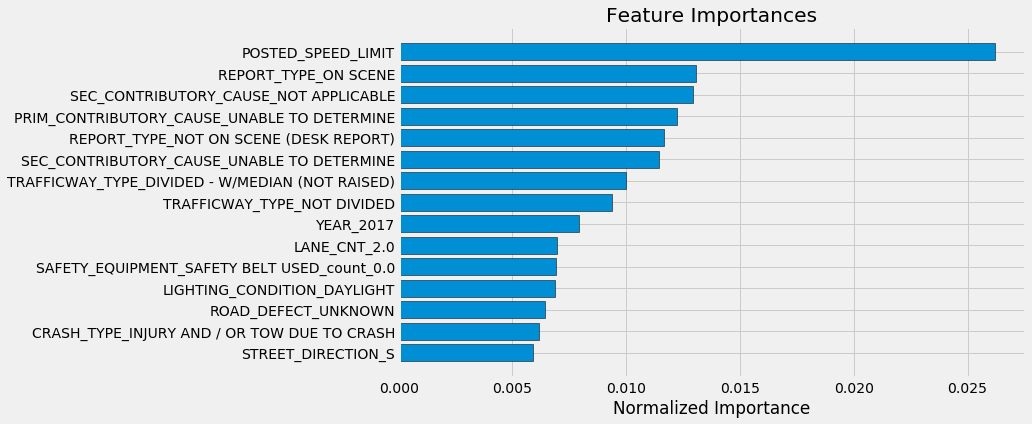

In [19]:
fi_raw_sorted = plot_feature_importances(fi_raw)

Examining the feature improtances, Let's find the percentage of the top 100 most important features that we made. However, rather than just compare to the original features, we need to compare to the one-hot encoded original features. These are already recorded for us in fi (from the original data).

In [20]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the people and vehicle data = %d.00' % len(new_features))

% of Top 100 Features created from the people and vehicle data = 43.00


## Test two model


In [21]:
# read in data

train = pd.read_csv('../input/train_people_vehicle_corrs_removed.csv',decimal = ',', dtype=dtypes, parse_dates = ['CRASH_DATE', 'DATE_POLICE_NOTIFIED'] )

In [22]:
train['YEAR'] = pd.DatetimeIndex(train['CRASH_DATE']).year

mask = train['YEAR']>2016

train=train.loc[mask,:]
train['YEAR']=train['YEAR'].astype('object')

train.shape


(207101, 883)

In [23]:
# drop same variables of control which is address info or date info.
drop_columns=['STREET_NO','LATITUDE','LONGITUDE','LOCATION','STREET_NAME','CRASH_DATE', 'DATE_POLICE_NOTIFIED']

#drop the features
train = train.drop(columns=drop_columns)

In [24]:
train.shape

(207101, 876)

In [25]:
# run and fit the model
fi_corr_removed, metrics_corr_removed = model(train)

Training Data Shape:  (207101, 4454)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.754835	train's binary_logloss: 0.583211	valid's auc: 0.731347	valid's binary_logloss: 0.592001
[400]	train's auc: 0.774028	train's binary_logloss: 0.570532	valid's auc: 0.732429	valid's binary_logloss: 0.590955
Early stopping, best iteration is:
[453]	train's auc: 0.77831	train's binary_logloss: 0.567665	valid's auc: 0.732611	valid's binary_logloss: 0.590754
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.754074	train's binary_logloss: 0.583888	valid's auc: 0.735203	valid's binary_logloss: 0.593348
[400]	train's auc: 0.772629	train's binary_logloss: 0.571594	valid's auc: 0.737575	valid's binary_logloss: 0.591531
[600]	train's auc: 0.786973	train's binary_logloss: 0.56174	valid's auc: 0.737998	valid's binary_logloss: 0.591003
[800]	train's auc: 0.799689	train's binary_logloss: 0.55256	valid's auc: 0.738782	valid's binary_logloss: 0.59

In [26]:
metrics_corr_removed

,fold,train,valid
0,0,0.778310,0.732611
1,1,0.842960,0.741642
2,2,0.816457,0.741352
3,3,0.797448,0.750999
4,4,0.804630,0.711580
5,overall,0.807961,0.736186


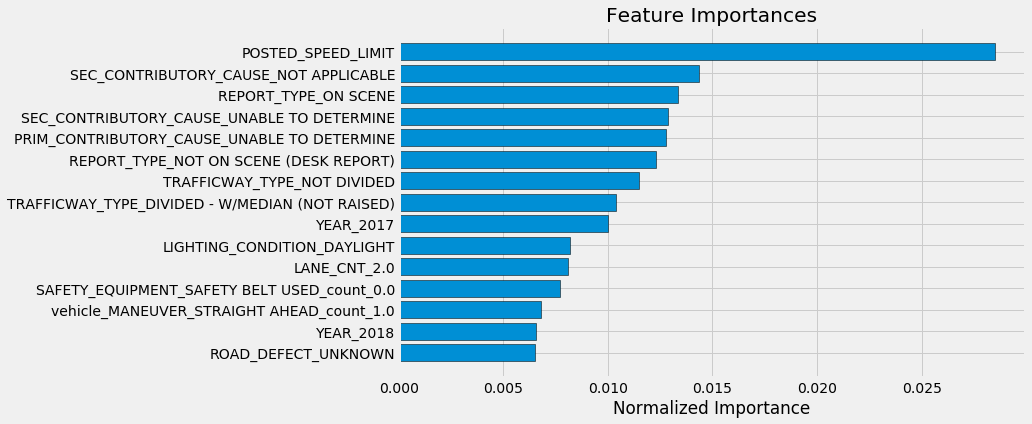

In [27]:
fi_corr_removed = plot_feature_importances(fi_corr_removed)

In [28]:
top_100 = list(fi_corr_removed['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the people and vehicle data = %d.00' % len(new_features))

% of Top 100 Features created from the people and vehicle data = 48.00


48 features out of top 100 features selected by importance are the variables that we added. 

# Results
After all that work, we can say that including the extra information did improve performance! The model is definitely not optimized to our data, but we still had a noticeable improvement over the original dataset when using the calculated features. Let's officially summarize the performances:

| Experiment | Train AUC | Validation AUC |
|------------|-----------|----------------|
|  Control   |  0.780612 |    0.720203    |
|  Test one  |  0.802836 |    0.736062    |
|  Test two  |  0.807961 |    0.736186    |

